In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# 导入数据

In [90]:
def get_data_excel(path):
    # data = pd.read_excel(path)
    data = pd.DataFrame(pd.read_excel('D:\OneDrive\Projects\Coding\Dachuang_20232024/data/bjtotal.xlsx'))
    data.dropna(inplace=True)
    # data = data[['time', 'price']]
    data = data.set_index('time', drop=True)
    # print(data_temp)
    
    # data.index = pd.to_datetime(data.index)
    # 假设 df 是您的 DataFrame，其中日期时间索引为 'datetime_index'
    df = data.sort_index(ascending=True)
    
    df.dropna(inplace=True)
    
    select_columns = ['count', 'temp', 'open4', 'close4', 'open94', 'close94','price']
    # select_columns = ['price']
    # select_columns = ["count", "aqi", "pm2_5", "pm10", "co", "no2", "o3", "so2", "complexindex", "temp", "humi", "windlevel", "open4", "close4", "open94", "close94", "price"]
    df = df[select_columns]
    print(df.head(5))
    # 打印排序后的 DataFrame
    return df

def get_data_csv(path):
    data = pd.read_excel(path)
    # data = pd.DataFrame(pd.read_excel('D:\OneDrive\Projects\Coding\Dachuang_20232024/data/bjtotal.xlsx'))
    data.dropna(inplace=True)
    # data = data[['time', 'price']]
    data = data.set_index('time', drop=True)
    # print(data_temp)
    
    data.index = pd.to_datetime(data.index)
    # 假设 df 是您的 DataFrame，其中日期时间索引为 'datetime_index'
    df = data.sort_index(ascending=True)
    
    df.dropna(inplace=True)
    
    select_columns = ['count', 'temp','aqi','pm2_5','co','pm10', 'open94', 'open4','price']

    
    df = df[select_columns]
    print(df.head(5))
    # 打印排序后的 DataFrame
    return df, df.head(3), df.columns

df = get_data_excel('D')

            count   temp     open4    close4   open94  close94  price
time                                                                 
2020-01-06    487  0.167  2409.645  2424.630  1420.98  1465.05   73.1
2020-01-07    400  0.750  2422.662  2439.392  1468.13  1468.94   76.2
2020-01-08    300  0.458  2438.344  2422.249  1469.20  1462.45   80.1
2020-01-09    350 -1.208  2427.006  2444.832  1476.34  1478.29   84.5
2020-02-18      1  2.292  2407.864  2416.302  1602.77  1628.85   84.5


# 数据预处理

In [91]:
from sklearn.ensemble import IsolationForest

def iso_tree(df):
    iso = IsolationForest(random_state=1, contamination='auto')
    preds = iso.fit_predict(df.values)
    df['cluster'] = preds
    print(df['cluster'].value_counts().sort_values(ascending=False))
    df = df[df['cluster'] != -1].drop(columns=['cluster'])
    print("处理后的数据框形状：", df.shape)
    return df

df = iso_tree(df)

cluster
 1    574
-1    171
Name: count, dtype: int64
处理后的数据框形状： (574, 7)


In [72]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# 输入序列(t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# 预测序列(t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# 把所有放在一起
	agg = concat(cols, axis=1)
	agg.columns = names
	# 删除空值行
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def prepare_data(df):
    values = df.values
    values = values.astype('float32')
    reframed = series_to_supervised(values, 90, 1)
    reframed.drop(reframed.columns[-7:-1], axis=1, inplace=True)
    print(reframed.head(3))
    
    scaler_s = StandardScaler()
    scaler_0 = MinMaxScaler(feature_range=(0,1))
    
    values = reframed.values
    values = scaler_s.fit_transform(values)
    
    n_train_hours = int(len(values)*0.8)
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    
    # train = scaler_s.fit_transform(train)
    # test = scaler_s.transform(test)
    train_x, train_y = train[:, :-1], train[:, -1]
    test_x, test_y = test[:, :-1], test[:, -1]
    
    train_x = train_x.reshape(train_x.shape[0], 1 , train_x.shape[1])
    test_x = test_x.reshape(test_x.shape[0], 1, test_x.shape[1])
    
    print(train_x.shape, train_y.shape)
    return train_x, train_y, test_x, test_y
    
    
train_x,train_y,test_x,test_y = prepare_data(df)


    var1(t-90)  var2(t-90)   var3(t-90)   var4(t-90)   var5(t-90)  \
90      3095.0      24.875  2615.447021  2708.541992  1739.709961   
91       220.0      27.375  2732.095947  2743.231934  1838.910034   
92      1548.0      27.375  2732.095947  2743.231934  1838.910034   

     var6(t-90)  var7(t-90)  var1(t-89)  var2(t-89)   var3(t-89)  ...  \
90  1810.619995   92.940002       220.0      27.375  2732.095947  ...   
91  1846.790039   22.000000      1548.0      27.375  2732.095947  ...   
92  1846.790039  100.000000     11186.0      26.955  2738.836914  ...   

      var6(t-2)  var7(t-2)  var1(t-1)  var2(t-1)    var3(t-1)    var4(t-1)  \
90  2082.709961  88.959999     1285.0     14.885  2733.860107  2751.875000   
91  2131.620117  54.000000     1784.0     14.885  2733.860107  2751.875000   
92  2131.620117  88.839996    13125.0     12.615  2743.806885  2760.183105   

      var5(t-1)    var6(t-1)  var7(t-1)    var7(t)  
90  2066.580078  2131.620117  54.000000  88.839996  
91  2066.58

In [41]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

def random_forest_regressor(df):
    
    scaler_s = StandardScaler()
    scaler_0 = MinMaxScaler(feature_range=(0,1))
    
    values = df.values
    values = scaler_s.fit_transform(values)
    
    # n_train_hours = int(len(values)*0.8)
    # train = values[:n_train_hours, :]
    # test = values[n_train_hours:, :]
    train = df
    feature_names = df.columns
    # train = scaler_s.fit_transform(train)
    # test = scaler_s.transform(test)
    # train_x, train_y = train[:, :-1], train[:, -1]
    train_x, train_y = train.iloc[:,:-1] , train.iloc[:,-1]
    # test_x, test_y = test[:, :-1], test[:, -1]
    train_x.head(2)
    train_y.head(2)
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # 训练模型
    rf.fit(train_x, train_y)
    
    # 获取特征重要性
    feature_importance = rf.feature_importances_
    
    # 将特征重要性与特征名称对应起来
    feature_importance_dict = dict(zip(feature_names, feature_importance))
    
    # 打印特征重要性
    print("特征重要性：", feature_importance_dict)
    
    # 选择重要性大于阈值的特征
    threshold = 0.05
    important_features = [feature for feature, importance in feature_importance_dict.items() if importance > threshold]
    
    # 打印选择的重要特征
    print("重要特征：", important_features)

random_forest_regressor(df)

特征重要性： {'count': 0.1821008578115463, 'aqi': 0.02667088656980675, 'pm2_5': 0.02484165283395207, 'pm10': 0.03362977908720152, 'co': 0.011663331410430007, 'no2': 0.02812830144940558, 'o3': 0.030630165461114543, 'so2': 0.009264413592571187, 'complexindex': 0.023138936022531094, 'temp': 0.08901063187551196, 'humi': 0.04327843899102728, 'windlevel': 0.03539037458310331, 'open4': 0.053667452946045226, 'close4': 0.2215116447212885, 'open94': 0.09692622332839491, 'close94': 0.0901469093160697}
重要特征： ['count', 'temp', 'open4', 'close4', 'open94', 'close94']


In [55]:
from keras import regularizers
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, BatchNormalization, Dropout
from keras.layers import LSTM


from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping

class LSTMmodel:
    def __init__(self, input_shape, units=50):
        self.input_shape = input_shape
        self.units = units
        self.model = self.build_model(input_shape)
    
    # def build_model(self, input_shape, units=100):
    #     model = Sequential()
    #     model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    #     model.add(Dropout(0.1))
    #     # model.add(LSTM(64, return_sequences=True))
    #     model.add(LSTM(32))
    #     model.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # 添加L2正则化
    #     model.add(Dropout(0.2))  # 添加Dropout层，丢弃率为0.2
    #     model.add(Dense(units=1))  # 输出层只有一个神经元，用于预测价格
    #     model.compile(loss='mean_squared_error', optimizer='adam')  # 使用均方误差作为损失函数
    #     return model
    
    def build_model(self, input_shape, units=100):
        model = Sequential()
        model.add(LSTM(2560, input_shape=input_shape, return_sequences=True))
        model.add(Dropout(0.1))
        model.add(LSTM(1280, return_sequences=True))  # 添加一个额外的LSTM层
        model.add(Dropout(0.1))  # 添加Dropout层
        model.add(LSTM(1280))  # 将第二个LSTM层改为32个单元
        model.add(Dense(units=320, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # 减少Dense层中的单元数量
        model.add(Dropout(0.2))  # 保留Dropout层
        model.add(Dense(units=1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model
    
    def train(self, train_x, train_y, epochs=50, batch_size=32, validation_data=None):
        # callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
        self.model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=validation_data)
        # , callbacks=callbacks)
        
    def predict(self, X):
        return self.model.predict(X)
    
    def showmodel(self):
        print(self.model.summary())

LSTM_model = LSTMmodel(input_shape=train_x.shape[1:], units=100) 
LSTM_model.train(train_x, train_y, epochs=2, batch_size=30, validation_data=(test_x, test_y))
LSTM_model.showmodel()


Epoch 1/100
18/18 [==============================] - 11s 357ms/step - loss: 4.3085 - val_loss: 3.7412
Epoch 2/100
18/18 [==============================] - 5s 279ms/step - loss: 2.2465 - val_loss: 1.9930
Epoch 3/100
18/18 [==============================] - 5s 288ms/step - loss: 1.3329 - val_loss: 1.6139
Epoch 4/100
18/18 [==============================] - 5s 285ms/step - loss: 0.8485 - val_loss: 1.1266
Epoch 5/100
18/18 [==============================] - 5s 279ms/step - loss: 0.6139 - val_loss: 0.8002
Epoch 6/100
18/18 [==============================] - 5s 272ms/step - loss: 0.4930 - val_loss: 0.9343
Epoch 7/100
18/18 [==============================] - 5s 268ms/step - loss: 0.4351 - val_loss: 0.8002
Epoch 8/100
18/18 [==============================] - 5s 279ms/step - loss: 0.4593 - val_loss: 0.9165
Epoch 9/100
18/18 [==============================] - 5s 292ms/step - loss: 0.3782 - val_loss: 0.5749
Epoch 10/100
18/18 [==============================] - 5s 272ms/step - loss: 0.3278 - val_l

KeyboardInterrupt: 

# 自动调优与模型重训练

In [9]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import regularizers

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), 
                   input_shape=(train_x.shape[1], train_x.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=512, step=32), 
                    activation='relu', 
                    kernel_regularizer=regularizers.l2(hp.Choice('l2_reg', values=[0.001, 0.01, 0.1]))))
    model.add(Dense(1))
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mse'])
    return model

tuner = kt.Hyperband(build_model,
                     objective='mse',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

tuner.search(train_x, train_y, epochs=20, validation_data=(test_x, test_y))

# 获取最优模型
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)


Trial 30 Complete [00h 00m 06s]
mse: 0.017108969390392303

Best mse So Far: 0.015043851919472218
Total elapsed time: 00h 01m 51s


In [10]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(train_x, train_y, epochs=100, validation_data=(test_x, test_y))


Epoch 1/100
13/13 [==============================] - 3s 70ms/step - loss: 0.8817 - mse: 0.6215 - val_loss: 0.8613 - val_mse: 0.6063
Epoch 2/100
13/13 [==============================] - 0s 16ms/step - loss: 0.5687 - mse: 0.3179 - val_loss: 0.9092 - val_mse: 0.6633
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 0.4460 - mse: 0.2042 - val_loss: 0.9622 - val_mse: 0.7254
Epoch 4/100
13/13 [==============================] - 0s 14ms/step - loss: 0.3851 - mse: 0.1520 - val_loss: 0.9107 - val_mse: 0.6821
Epoch 5/100
13/13 [==============================] - 0s 8ms/step - loss: 0.3299 - mse: 0.1051 - val_loss: 0.8840 - val_mse: 0.6637
Epoch 6/100
13/13 [==============================] - 0s 8ms/step - loss: 0.2923 - mse: 0.0756 - val_loss: 0.8444 - val_mse: 0.6322
Epoch 7/100
13/13 [==============================] - 0s 8ms/step - loss: 0.2582 - mse: 0.0494 - val_loss: 0.8532 - val_mse: 0.6487
Epoch 8/100
13/13 [==============================] - 0s 11ms/step - loss: 0.2337

## AUTOTRANSFORMER

In [92]:
def prepare_data1(df):
    values = df.values
    reframed = values.astype('float32')
    # reframed.drop(reframed.columns[-7:-1], axis=1, inplace=True)
    print(reframed)
    
    scaler_s = StandardScaler()
    scaler_0 = MinMaxScaler(feature_range=(0,1))
    
    values = reframed.values
    values = scaler_s.fit_transform(values)
    
    n_train_hours = int(len(values)*0.8)
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    
    # train = scaler_s.fit_transform(train)
    # test = scaler_s.transform(test)
    train_x, train_y = train[:, :-1], train[:, -1]
    test_x, test_y = test[:, :-1], test[:, -1]
    
    train_x = train_x.reshape(train_x.shape[0], 1 , train_x.shape[1])
    test_x = test_x.reshape(test_x.shape[0], 1, test_x.shape[1])
    
    print(train_x.shape, train_y.shape)
    return train_x, train_y, test_x, test_y
    
    
train_x,train_y,test_x,test_y = prepare_data1(df)
print(train_x)

[[3.095000e+03 2.487500e+01 2.615447e+03 ... 1.739710e+03 1.810620e+03
  9.294000e+01]
 [2.200000e+02 2.737500e+01 2.732096e+03 ... 1.838910e+03 1.846790e+03
  2.200000e+01]
 [1.548000e+03 2.737500e+01 2.732096e+03 ... 1.838910e+03 1.846790e+03
  1.000000e+02]
 ...
 [8.000000e+02 2.525000e+00 2.700090e+03 ... 1.845520e+03 1.840290e+03
  1.070000e+02]
 [1.389900e+04 4.271000e+00 2.694248e+03 ... 1.853010e+03 1.835510e+03
  1.150000e+02]
 [2.000000e+00 4.271000e+00 2.694248e+03 ... 1.853010e+03 1.835510e+03
  7.200000e+01]]


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [83]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self):
        super(PositionalEncoding, self).__init__()

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / tf.pow(10000, (2 * tf.cast(i, tf.float32) / tf.cast(d_model, tf.float32)))
        return pos * angle_rates

    def call(self, inputs):
        seq_length = inputs.shape[1]
        d_model = inputs.shape[2]
        angles = self.get_angles(tf.range(seq_length)[:, tf.newaxis], tf.range(d_model)[tf.newaxis, :], d_model)
        angles = tf.cast(angles, tf.float32)
        angles = tf.expand_dims(angles, axis=0)
        pos_encoding = tf.sin(angles[:, :, 0::2]) + tf.cos(angles[:, :, 1::2])
        return inputs + pos_encoding

class Autotransformer(tf.keras.Model):
    def __init__(self, input_shape, num_layers=4, d_model=64, num_heads=4, dropout=0.1):
        super(Autotransformer, self).__init__()
        
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dropout = dropout
        
        self.inputs = Input(shape=input_shape)
        self.positional_encoding = PositionalEncoding()
        self.autotransformer_layers = [self.build_autotransformer_layer() for _ in range(num_layers)]
        self.outputs = Dense(input_shape[1])
        
    def build_autotransformer_layer(self):
        self_attention = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.d_model)
        dense_1 = Dense(self.d_model, activation='relu')
        dropout_1 = Dropout(self.dropout)
        normalization_1 = LayerNormalization()
        
        dense_2 = Dense(self.d_model)
        dropout_2 = Dropout(self.dropout)
        normalization_2 = LayerNormalization()
        
        return (self_attention, dense_1, dropout_1, normalization_1, dense_2, dropout_2, normalization_2)
        
    def call(self, inputs):
        x = self.inputs(inputs)
        x = self.positional_encoding(x)
        
        for self_attention, dense_1, dropout_1, normalization_1, dense_2, dropout_2, normalization_2 in self.autotransformer_layers:
            x = self_attention(x, x)
            x = dropout_1(x)
            x = normalization_1(x + inputs)
            
            x = dense_1(x)
            x = dropout_2(x)
            x = normalization_2(x + inputs)
        
        return self.outputs(x)

# 使用示例
input_shape = (387, 630)# 除了样本数之外的部分
autotransformer_model = Autotransformer(input_shape=input_shape)
autotransformer_model.compile(optimizer='adam', loss='mean_squared_error')
autotransformer_model.fit(train_x, train_y, epochs=100, batch_size=30, validation_data=(test_x, test_y))


Epoch 1/100


TypeError: in user code:

    File "D:\Program Files\anaconda\envs\TensorwithPyQt6\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "D:\Program Files\anaconda\envs\TensorwithPyQt6\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Program Files\anaconda\envs\TensorwithPyQt6\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "D:\Program Files\anaconda\envs\TensorwithPyQt6\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "D:\Program Files\anaconda\envs\TensorwithPyQt6\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\DOGE\AppData\Local\Temp\__autograph_generated_file8psmmuw2.py", line 10, in tf__call
        x = ag__.converted_call(ag__.ld(self).inputs, (ag__.ld(inputs),), None, fscope)

    TypeError: Exception encountered when calling layer "autotransformer_10" "                 f"(type Autotransformer).
    
    in user code:
    
        File "C:\Users\DOGE\AppData\Local\Temp\ipykernel_10664\1828289329.py", line 48, in call  *
            x = self.inputs(inputs)
    
        TypeError: 'KerasTensor' object is not callable
    
    
    Call arguments received by layer "autotransformer_10" "                 f"(type Autotransformer):
      • inputs=tf.Tensor(shape=(None, 1, 630), dtype=float32)


# 结果输出

17/17 [==============================] - 0s 3ms/step
The R2 score on the Train set is:	0.979
The R2 score on the Test set is:	-0.118
5/5 [==============================] - 0s 3ms/step


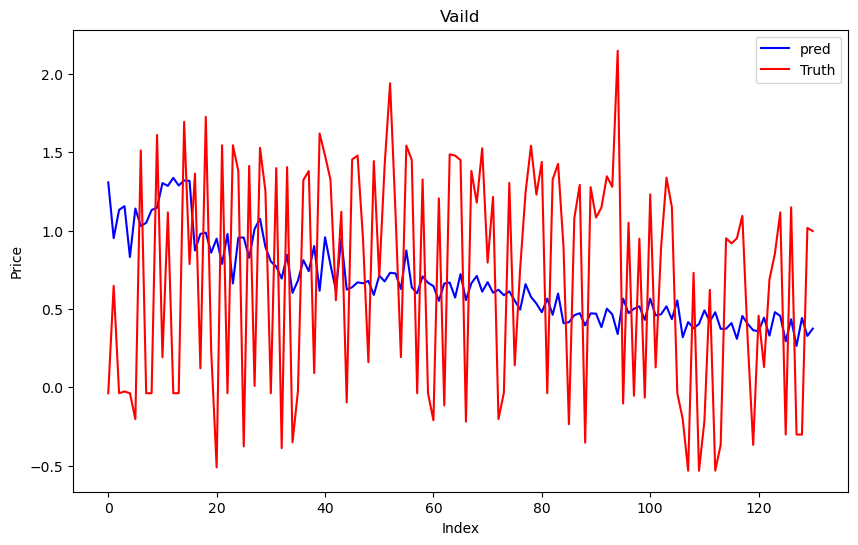

17/17 [==============================] - 0s 3ms/step
The R2 score on the Train set is:	0.979
The R2 score on the Test set is:	-0.118
17/17 [==============================] - 0s 3ms/step


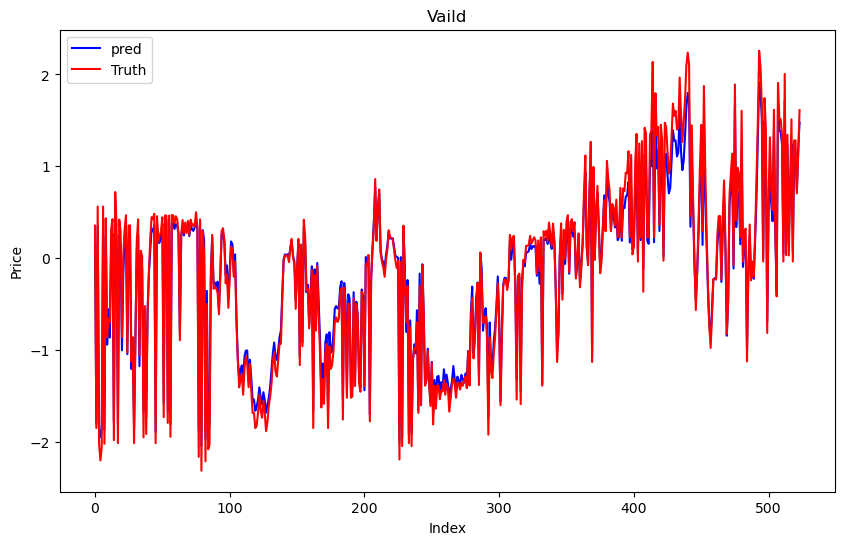

array([[ 1.53902426e-01],
       [-1.80459750e+00],
       [ 3.48603994e-01],
       [-1.83538771e+00],
       [-1.95207584e+00],
       [-1.88078356e+00],
       [ 4.04328793e-01],
       [-1.87144494e+00],
       [ 2.35376805e-01],
       [-9.43711042e-01],
       [-5.59032261e-01],
       [-8.65916848e-01],
       [ 1.23939574e-01],
       [ 2.58545965e-01],
       [-1.79016590e+00],
       [ 4.52661186e-01],
       [ 1.89334869e-01],
       [-1.82009721e+00],
       [ 2.44061738e-01],
       [ 1.47930145e-01],
       [-1.00589252e+00],
       [-1.75048545e-01],
       [ 2.41334498e-01],
       [ 2.86412925e-01],
       [-1.04741263e+00],
       [ 2.07425684e-01],
       [ 1.96830273e-01],
       [-1.20906711e+00],
       [-9.38506603e-01],
       [-1.84138703e+00],
       [-8.57101083e-01],
       [ 9.29492414e-02],
       [ 2.48608738e-01],
       [-1.17818844e+00],
       [ 3.81280966e-02],
       [-1.24257132e-01],
       [-1.66375387e+00],
       [-5.63515544e-01],
       [-1.7

In [54]:
def pred_plt(test_X, test_y):
    score(test_x, train_x)
    pred_x = LSTM_model.predict(test_X)
    # pred_x =best_model.predict(test_X)
    plt.figure(figsize=(10, 6))
    plt.plot(pred_x, label='pred', color='blue')
    plt.plot(test_y, label='Truth', color='red')
    plt.legend()
    plt.title('Vaild')
    plt.xlabel('Index')
    plt.ylabel('Price')
    # plt.xlim(0, 30)
    plt.show()
    
    return pred_x

from sklearn.metrics import r2_score


def score(test, train):
    a= LSTM_model.predict(test)
    
    b = LSTM_model.predict(train)
    
    print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(train_y, b)))
    
    print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(test_y, a)))
    
    
pred_plt(test_x, test_y)
pred_plt(train_x, train_y)

In [51]:
def pred_plt(test_X, test_y):
    score(test_x, train_x)
    pred_x = best_model.predict(test_X)
    plt.figure(figsize=(10, 6))
    plt.plot(pred_x, label='pred', color='blue')
    plt.plot(test_y, label='Truth', color='red')
    plt.legend()
    plt.title('Vaild')
    plt.xlabel('Index')
    plt.ylabel('Price')
    # plt.xlim(0, 30)
    plt.show()
    
    return pred_x

from sklearn.metrics import r2_score


def score(test, train):
    a= best_model.predict(test)
    
    b = best_model.predict(train)
    
    print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(train_y, b)))
    
    print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(test_y, a)))
    
    
pred_plt(test_x, test_y)
pred_plt(train_x, train_y)

InvalidArgumentError: Graph execution error:

Specified a list with shape [?,450] from a tensor with shape [32,630]
	 [[{{node TensorArrayUnstack/TensorListFromTensor}}]]
	 [[sequential_2/lstm_2/PartitionedCall]] [Op:__inference_predict_function_436685]